<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignment 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [153]:
##### Your Code Here #####

from tensorflow.keras.datasets import boston_housing

In [154]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [98]:
# need to normalize the data

def normalize(array_set):
    array_set = array_set.astype('float32') / array_set.max(axis=0)
    return array_set

In [99]:
# apply normalizing function

# X_train = normalize(X_train)
# X_test = normalize(X_test)

In [155]:
# what is the len of X_train observation?

len(X_train[0])

13

In [201]:
# import the model and layers to use in model architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Instantiate sequential model with layers

model = Sequential([
    
    Dense(13, activation='relu', input_shape=(13,)),
    Dense(1)]
)

# complie the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# fit the model
fitted = model.fit(
    x=X_train, 
    y=y_train, 
    epochs=5, 
    validation_data=(X_test, y_test),
)

Epoch 1/5
13/13 [==============================] - 0s 7ms/step - loss: 270.4600 - mean_squared_error: 270.4600 - val_loss: 203.0534 - val_mean_squared_error: 203.0534
Epoch 2/5
13/13 [==============================] - 0s 4ms/step - loss: 173.6527 - mean_squared_error: 173.6527 - val_loss: 162.4937 - val_mean_squared_error: 162.4937
Epoch 3/5
13/13 [==============================] - 0s 4ms/step - loss: 142.8938 - mean_squared_error: 142.8938 - val_loss: 144.5677 - val_mean_squared_error: 144.5677
Epoch 4/5
13/13 [==============================] - 0s 4ms/step - loss: 126.0058 - mean_squared_error: 126.0058 - val_loss: 135.2669 - val_mean_squared_error: 135.2669
Epoch 5/5
13/13 [==============================] - 0s 4ms/step - loss: 116.3545 - mean_squared_error: 116.3545 - val_loss: 124.6508 - val_mean_squared_error: 124.6508


In [202]:
pd.DataFrame(fitted.history).reset_index().rename(columns={'index': 'epoch'}).head()

,epoch,loss,mean_squared_error,val_loss,val_mean_squared_error
0,0,270.460022,270.460022,203.053360,203.053360
1,1,173.652679,173.652679,162.493683,162.493683
2,2,142.893799,142.893799,144.567657,144.567657
3,3,126.005760,126.005760,135.266922,135.266922
4,4,116.354500,116.354500,124.650764,124.650764


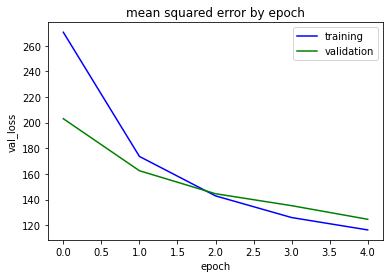

In [203]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

training_mse = pd.DataFrame(fitted.history)['loss']
validation_mse = pd.DataFrame(fitted.history)['val_loss']
epoch = pd.DataFrame(fitted.history).reset_index().rename(columns={'index': 'epoch'})['epoch']



plt.title('mean squared error by epoch')


sns.lineplot(x=epoch, y=training_mse, color='blue')
sns.lineplot(x=epoch, y=validation_mse, color='green')

plt.legend(labels=['training', 'validation'])

plt.show()

#### Apply a linear regression and compare

In [189]:
#reimport dataset to use in a linear regression model:

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()


In [190]:
dummy = X_train.astype('float32') / X_train.max(axis=0) 

In [191]:
# apply normalizing function

# X_train = normalize(X_train)
# X_test = normalize(X_test)

In [192]:
dummy[0] == X_train[0]

array([False,  True, False,  True, False, False, False, False, False,
       False, False, False, False])

In [193]:
# get data into a dataframe

def make_dataframe(array_set):
    columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    df = pd.DataFrame(array_set)
    df.columns = columns
    return df
    


In [194]:
X_train = make_dataframe(X_train)
X_test = make_dataframe(X_test)

In [195]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [196]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [197]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [198]:
len(pred) == len(y_test)

True

In [199]:
mse = mean_squared_error(y_test, pred)
mse

23.195599256422906

#### Engineer some new features and retest with NN and LinearRegression

In [185]:
X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21977,0.0,6.91,0.0,0.4480,5.602,62.0,6.0877,3.0,233.0,17.9,396.90,16.20
400,0.16211,20.0,6.96,0.0,0.4640,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59
401,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
402,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79


## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- The number of nodes in your output layer should equal the number of classes you want to predict for Fashion-MNIST.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [233]:
from tensorflow.keras.datasets import fashion_mnist

In [234]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [235]:
train_images.shape

(60000, 28, 28)

In [236]:
print(len(train_images) ==  len(train_labels))
print(len(test_images) ==  len(test_labels))

True
True


In [237]:
import numpy as np
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [238]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

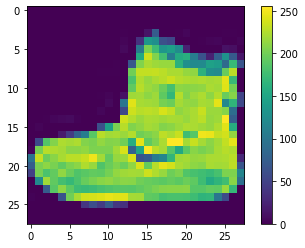

In [239]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [240]:
train_images = train_images.astype('float32') / 255.0

test_images = test_images.astype('float32') / 255.0

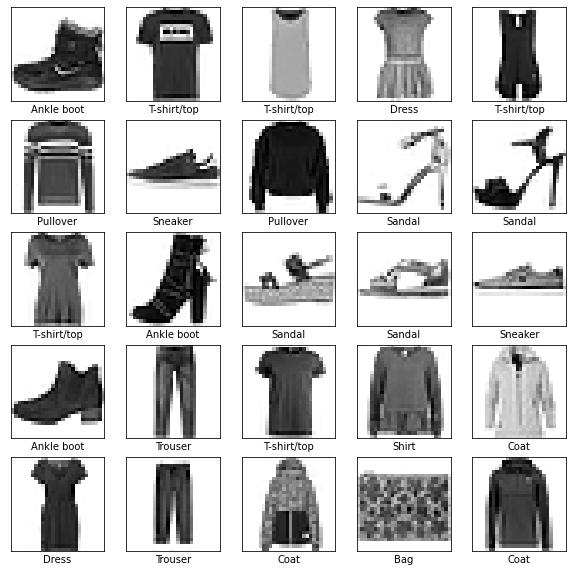

In [241]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [270]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='tanh'),
    Dense(10, activation='softmax')
   
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [271]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_43 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [272]:
train_images.shape

(60000, 28, 28)

In [273]:
fitted = model.fit(
    x=train_images, 
    y=train_labels, 
    epochs=5,
    validation_data=(test_images, test_labels)
    
)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4832 - accuracy: 0.8256 - val_loss: 0.4304 - val_accuracy: 0.8429
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3755 - accuracy: 0.8622 - val_loss: 0.4334 - val_accuracy: 0.8442
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3394 - accuracy: 0.8742 - val_loss: 0.3958 - val_accuracy: 0.8535
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3168 - accuracy: 0.8815 - val_loss: 0.3416 - val_accuracy: 0.8738
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2986 - accuracy: 0.8892 - val_loss: 0.3610 - val_accuracy: 0.8720


In [268]:
pd.DataFrame(fitted.history).reset_index().rename(columns={'index': 'epoch'})

,epoch,loss,accuracy,val_loss,val_accuracy
0,0,0.479001,0.827917,0.426058,0.8460
1,1,0.370127,0.864550,0.387740,0.8614
2,2,0.335449,0.878500,0.380182,0.8600
3,3,0.311255,0.885367,0.351094,0.8724
4,4,0.294627,0.891067,0.367569,0.8687


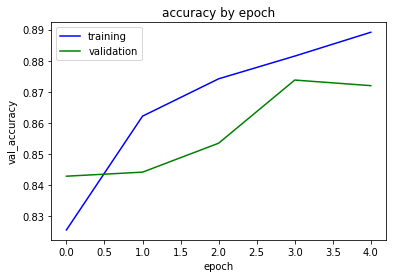

In [283]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

training_accuracy = pd.DataFrame(fitted.history)['accuracy']
validation_accuracy = pd.DataFrame(fitted.history)['val_accuracy']
epoch = pd.DataFrame(fitted.history).reset_index().rename(columns={'index': 'epoch'})['epoch']



plt.title('accuracy by epoch')


sns.lineplot(x=epoch, y=training_accuracy, color='blue')
sns.lineplot(x=epoch, y=validation_accuracy, color='green')

plt.legend(labels=['training', 'validation'])

plt.show()

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5057 - accuracy: 0.8197 - val_loss: 0.4481 - val_accuracy: 0.8382
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3844 - accuracy: 0.8606 - val_loss: 0.3977 - val_accuracy: 0.8562
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3431 - accuracy: 0.8755 - val_loss: 0.3871 - val_accuracy: 0.8588
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3147 - accuracy: 0.8846 - val_loss: 0.3522 - val_accuracy: 0.8714
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2915 - accuracy: 0.8911 - val_loss: 0.3522 - val_accuracy: 0.8729
Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4743 - accuracy: 0.8285 - val_loss: 0.4207 - val_accuracy: 0.8535
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3769 - accuracy: 0.8612 - val_loss: 0.3998 - val_accuracy: 0.8566

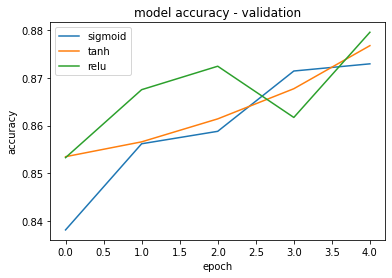

In [279]:
epochs = 5

for activation in ['sigmoid', 'tanh', 'relu']:
    
    # instantiate the Sequential model
    model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation=activation),
    Dense(10, activation='softmax')
    ])
    
    # compile model
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    # fit model and save to a results variable to use in plotting.
    results = model.fit(
        x=train_images, 
        y=train_labels, 
        epochs=5,
        validation_data=(test_images, test_labels)
    )
    
    plt.plot(results.history['val_accuracy'])
    
    
# plot the accuracy results for each activation
plt.title('model accuracy - validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['sigmoid', 'tanh', 'relu'], loc='upper left')

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.